In [1]:
import astropy
from astropy.timeseries import LombScargle
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astroplan.plots import plot_airmass
from astroplan import Observer, FixedTarget
import astropy.units as u
from tqdm import tqdm

np.random.seed(42)

In [2]:
observer = Observer.at_site('lapalma')
coordinates = SkyCoord('00h00m00.0s', '+45d00m00.0s', frame='icrs')
target = FixedTarget(name='target star', coord=coordinates)

In [3]:
survey_start = Time('2021-03-01 00:00:00')
survey_end = Time('2022-03-01 00:00:00')
survey_dates = [survey_start + n*TimeDelta(1.*u.day) for n in range(365)]

In [4]:
t_zeniths = np.zeros(len(survey_dates)) + np.nan
t_randomized = np.zeros(len(survey_dates)) + np.nan
sunsets = np.array([])
sunrises = np.array([])

for i,t in tqdm(enumerate(survey_dates)):
    t_rise = observer.target_rise_time(t, target, which='nearest')
    t_set = observer.target_set_time(t_rise, target, which='next')
    t_zenith = t_rise + (t_set - t_rise)/2.
    if observer.is_night(t_zenith):
        t_zeniths[i] = t_zenith.jd
    # the following is slow but idk how to be more clever in astroplan:
    for j in range(100):
        t_random = t_zenith + (np.random.random() * 16. - 8.) * TimeDelta(1.*u.hour) # perturb by 8 hours in either direction
        if observer.is_night(t_random) and observer.altaz(t_random, target).secz.value < 1.5:
            t_randomized[i] = t_random.jd
            break

0it [00:00, ?it/s]WARNING: Tried to get polar motions for times after IERS data is valid. Defaulting to polar motion from the 50-yr mean for those. This may affect precision at the 10s of arcsec level [astropy.coordinates.builtin_frames.utils]
365it [07:09,  1.18s/it]


In [5]:
airmasses_zenith = np.zeros_like(t_zeniths)
for i,tz in enumerate(t_zeniths):
    try:
        airmasses_zenith[i] = observer.altaz(Time(tz, format='jd'), target).secz.value
    except ValueError:
        continue

In [6]:
airmasses_random = np.zeros_like(t_randomized)
for i,tr in enumerate(t_randomized):
    try:
        airmasses_random[i] = observer.altaz(Time(tr, format='jd'), target).secz.value
    except ValueError:
        continue

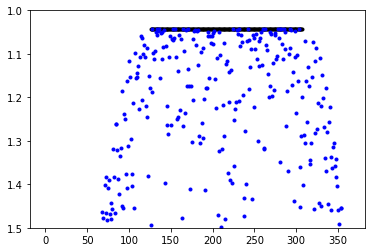

In [7]:
plt.plot(airmasses_zenith, 'k.')
plt.plot(airmasses_random, 'b.')
plt.ylim([1.5,1.0]);

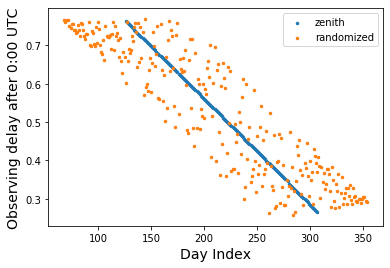

In [8]:
day_inds = np.arange(len(t_zeniths))
plt.scatter(day_inds, t_zeniths % 1.0, label='zenith', s=6)
plt.scatter(day_inds, t_randomized % 1.0, label='randomized', s=6)
plt.xlabel('Day Index', fontsize=14)
plt.ylabel('Observing delay after 0:00 UTC', fontsize=14)
plt.legend();
#plt.plot(day_inds, sunrises, label='sunrise')
#plt.plot(day_inds, sunsets, label='sunset')

In [9]:
t_obs_zenith = t_zeniths[np.isfinite(t_zeniths)]
t_obs_zenith += np.random.normal(0., 30./60./24., len(t_obs_zenith)) # 30-minute perturbation

In [10]:
airmasses = [observer.altaz(Time(to, format='jd'), target).secz.value for to in t_obs_zenith]

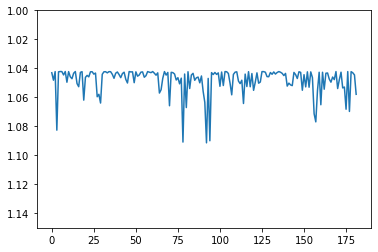

In [11]:
plt.plot(airmasses)
plt.ylim([1.15,1.0]);

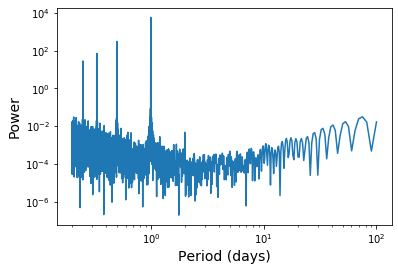

In [12]:
ys_zenith = np.ones_like(t_obs_zenith)/len(t_obs_zenith)
frequency, power_zenith = LombScargle(t_obs_zenith, 
                                      ys_zenith).autopower(minimum_frequency=0.01,
                                                   maximum_frequency=5.,
                                                   samples_per_peak=5)
plt.loglog(1./frequency, power_zenith)
plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Power', fontsize=14);
#plt.axvline(0.33, color='C1', alpha=0.7, ls='--');

In [13]:
t_obs_randomized = t_randomized[np.isfinite(t_randomized)]
ys_randomized = np.ones_like(t_obs_randomized)/len(t_obs_randomized)

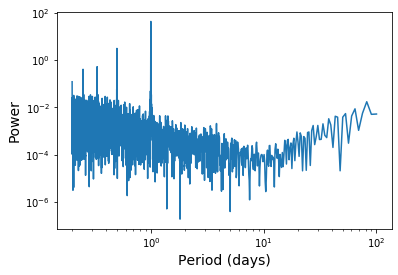

In [14]:
power_randomized = LombScargle(t_obs_randomized, 
                               ys_randomized).power(frequency)
plt.loglog(1./frequency, power_randomized)
plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Power', fontsize=14);
#plt.axvline(0.33, color='C1', alpha=0.7, ls='--');

In [15]:
len(t_obs_randomized)

285

In [16]:
len(t_obs_zenith)

182

There are fewer observations for the case of zenith because the algorithm I wrote flat-out rejects any nights where zenith does not fall during the night, so we're losing out on the edges of the observing season.